# Binary Classification of Insurance Cross Selling

**Цель - предсказать, какие клиенты положительно отреагируют на предложение по автострахованию.**

*Описание датасета:*

**id:** Уникальный идентификатор для каждого учащегося.

**Gender:** The gender of the customer.

**Age:** Возраст клиента.

**Driving_License:** Указывает, есть ли у клиента водительские права (1 = да, 0 = нет).

**Region_Code:** Уникальный код, обозначающий регион клиента.

**Previously_Insured:** Указывает, имеет ли клиент уже страховку транспортного средства (1 = да, 0 = нет).

**Vehicle_Age:** Возраст транспортного средства.

**Vehicle_Damage:** Указывает, были ли у клиента повреждения автомобиля в прошлом (1 = да, 0 = нет).

**Annual_Premium:** Сумма годовой премии, которую должен заплатить клиент.

**Policy_Sales_Channel:** Анонимный код для различных каналов связи с клиентами, таких как агенты, электронная почта, телефонные звонки и т.д.

**Vintage:** Количество дней, в течение которых клиент был связан со страховой компанией.

**Response:** Целевая переменная, указывающая, заинтересован ли клиент (1 = Заинтересован, 0 = Не заинтересован).

## Метод случайного леса

Метод случайного леса (англ. random forest) — алгоритм машинного обучения, предложенный Лео Брейманом и Адель Катлер, заключающийся в использовании ансамбля решающих деревьев. Алгоритм сочетает в себе две основные идеи: метод бэггинга Бреймана и метод случайных подпространств, предложенный Тин Кам Хо. Алгоритм применяется для задач классификации, регрессии и кластеризации. Основная идея заключается в использовании большого ансамбля решающих деревьев, каждое из которых само по себе даёт очень невысокое качество классификации, но за счёт их большого количества результат получается хорошим. 

### Алгоритм

Алгоритм построения случайного леса, состоящего из $\large N$ деревьев, выглядит следующим образом:
* Для каждого $\large n = 1, \dots, N$:
     * Сгенерировать выборку $\large X_n$ с помощью bootstrap.
     * Построить решающее дерево $\large b_n$ по выборке $\large X_n$:
         — по заданному критерию мы выбираем лучший признак, делаем разбиение в дереве по нему и так до исчерпания выборки
         — дерево строится, пока в каждом листе не более $\large n_\text{min}$ объектов или пока не достигнем определенной высоты дерева
         — при каждом разбиении сначала выбирается $\large m$ случайных признаков из $\large n$ исходных, 
         и оптимальное разделение выборки ищется только среди них.
         
Итоговый классификатор $\large a(x) = \frac{1}{N}\sum_{i = 1}^N b_i(x)$, простыми словами — для задачи кассификации мы выбираем решение голосованием по большинству, а в задаче регрессии — средним.

Рекомендуется в задачах классификации брать $\large m = \sqrt{n}$, а в задачах регрессии — $\large m = \frac{n}{3}$, где $\large n$ — число признаков. Также рекомендуется в задачах классификации строить каждое дерево до тех пор, пока в каждом листе не окажется по одному объекту, а в задачах регрессии — пока в каждом листе не окажется по пять объектов.

# Импорт библиотек

In [5]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Загрузка и предварительная обработка данных

In [38]:
# Загрузка данных
data = pd.read_csv('data.csv')

# Просмотр первых строк
data.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [20]:
# Общая информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Dtype  
---  ------                -----  
 0   Gender                object 
 1   Age                   int64  
 2   Driving_License       int64  
 3   Region_Code           float64
 4   Previously_Insured    int64  
 5   Vehicle_Age           object 
 6   Vehicle_Damage        object 
 7   Annual_Premium        float64
 8   Policy_Sales_Channel  float64
 9   Vintage               int64  
 10  Response              object 
dtypes: float64(3), int64(4), object(4)
memory usage: 965.5+ MB


In [39]:
data['Vehicle_Damage'] = data['Vehicle_Damage'].astype(str).astype('str')
data['Response'] = data['Response'].astype(str).astype('str')
data['Gender'] = data['Gender'].astype(str).astype('str')
data = data.drop(columns=['id'])

# Разведочный анализ данных (EDA) 

In [8]:
desc = pd.DataFrame(index = list(data))
desc['type'] = data.dtypes
desc['count'] = data.count()
desc['nunique'] = data.nunique()
desc['%unique'] = desc['nunique'] /len(data) * 100
desc['null'] = data.isnull().sum()
desc['%null'] = desc['null'] / len(data) * 100
desc = pd.concat([desc,data.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(axis=0)

,type,count,nunique,%unique,null,%null,mean,std,min,25%,50%,75%,max
Age,int64,11504798,66,0.000574,0,0.000000,38.383563,14.993459,20.000000,24.000000,36.000000,49.000000,85.000000
Driving_License,int64,11504798,2,0.000017,0,0.000000,0.998022,0.044431,0.000000,1.000000,1.000000,1.000000,1.000000
Previously_Insured,int64,11504798,2,0.000017,0,0.000000,0.462997,0.498629,0.000000,0.000000,0.000000,1.000000,1.000000
Vintage,int64,11504798,290,0.002521,0,0.000000,163.897744,79.979531,10.000000,99.000000,166.000000,232.000000,299.000000
Region_Code,float64,11504798,54,0.000469,0,0.000000,26.418690,12.991590,0.000000,15.000000,28.000000,35.000000,52.000000
Annual_Premium,float64,11504798,51728,0.449621,0,0.000000,30461.370411,16454.745205,2630.000000,25277.000000,31824.000000,39451.000000,540165.000000
Policy_Sales_Channel,float64,11504798,152,0.001321,0,0.000000,112.425442,54.035708,1.000000,29.000000,151.000000,152.000000,163.000000
Gender,object,11504798,2,0.000017,0,0.000000,nan,nan,nan,nan,nan,nan,nan
Vehicle_Age,object,11504798,3,0.000026,0,0.000000,nan,nan,nan,nan,nan,nan,nan
Vehicle_Damage,object,11504798,2,0.000017,0,0.000000,nan,nan,nan,nan,nan,nan,nan


In [9]:
# Категориальный анализ
categorical_columns = data.select_dtypes(include=['object']).columns
unique_counts = data[categorical_columns].nunique()
print(unique_counts)

Gender            2
Vehicle_Age       3
Vehicle_Damage    2
Response          2
dtype: int64


**Проверка количества значений для специфичных столбцов:**

In [10]:
data.Gender.value_counts(normalize=True)

Gender
Male      0.541351
Female    0.458649
Name: proportion, dtype: float64

In [11]:
data.Vehicle_Damage.value_counts(normalize=True)

Vehicle_Damage
Yes    0.50268
No     0.49732
Name: proportion, dtype: float64

In [12]:
data.Vehicle_Age.value_counts(normalize=True)

Vehicle_Age
1-2 Year     0.520016
< 1 Year     0.438438
> 2 Years    0.041546
Name: proportion, dtype: float64

# Визуализация распределения данных

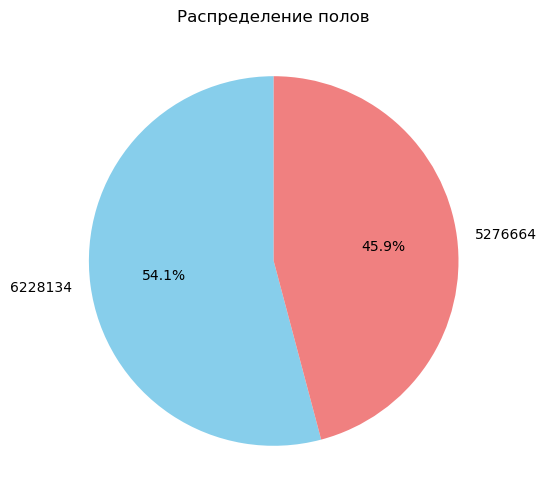

In [14]:
gender_counts = data['Gender'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(gender_counts, labels=gender_counts, autopct='%1.1f%%', colors=['skyblue', 'lightcoral'], startangle=90)
plt.title('Распределение полов')
plt.show()

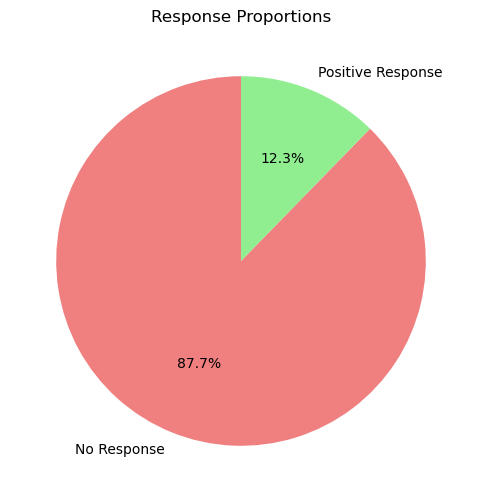

In [15]:
# Response proportions
response_counts = data['Response'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(response_counts, labels=['No Response', 'Positive Response'], autopct='%1.1f%%', colors=['lightcoral', 'lightgreen'], startangle=90)
plt.title('Response Proportions')
plt.show()

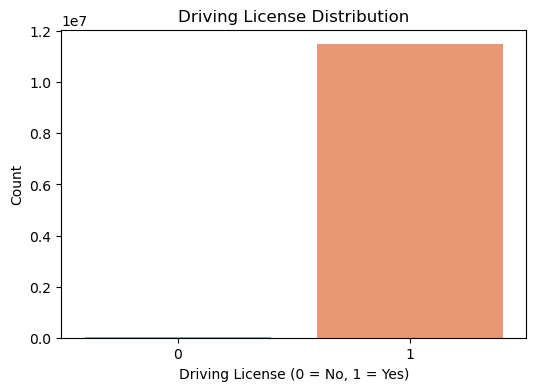

In [17]:
# Driving License distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Driving_License', data=data, palette='Set2')
plt.title('Driving License Distribution')
plt.xlabel('Driving License (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()

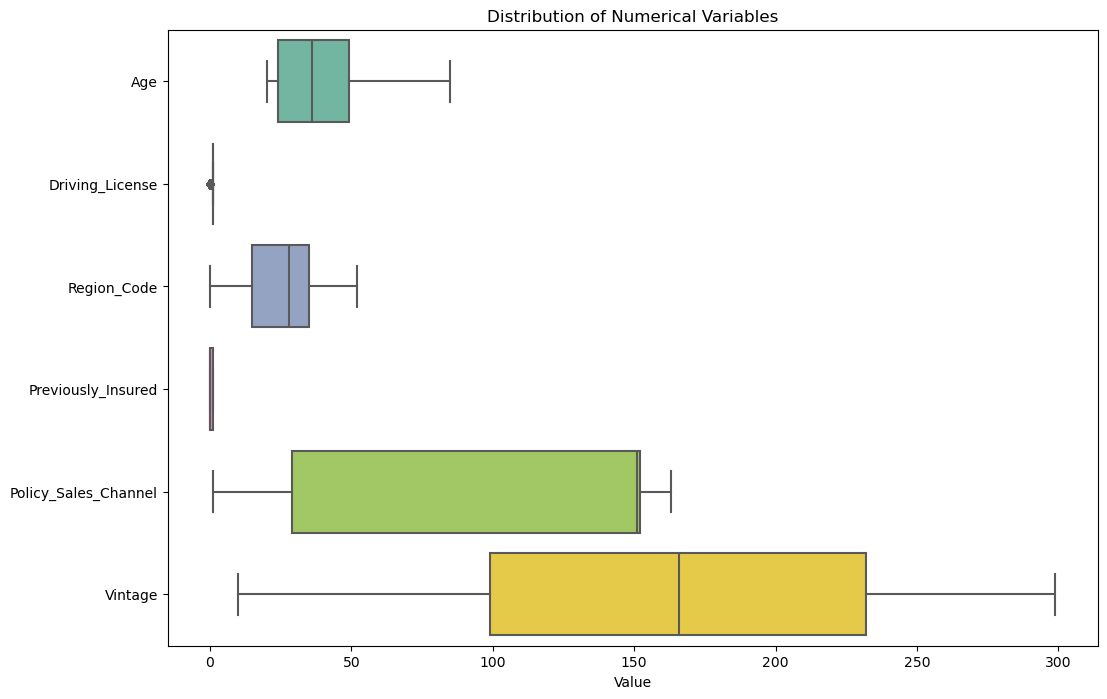

In [18]:
# Boxplot for numerical variables
numerical_cols = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 
                  'Policy_Sales_Channel', 'Vintage', 'Response']
plt.figure(figsize=(12, 8))
sns.boxplot(data=data[numerical_cols], orient='h', palette='Set2')
plt.title('Distribution of Numerical Variables')
plt.xlabel('Value')
plt.show()

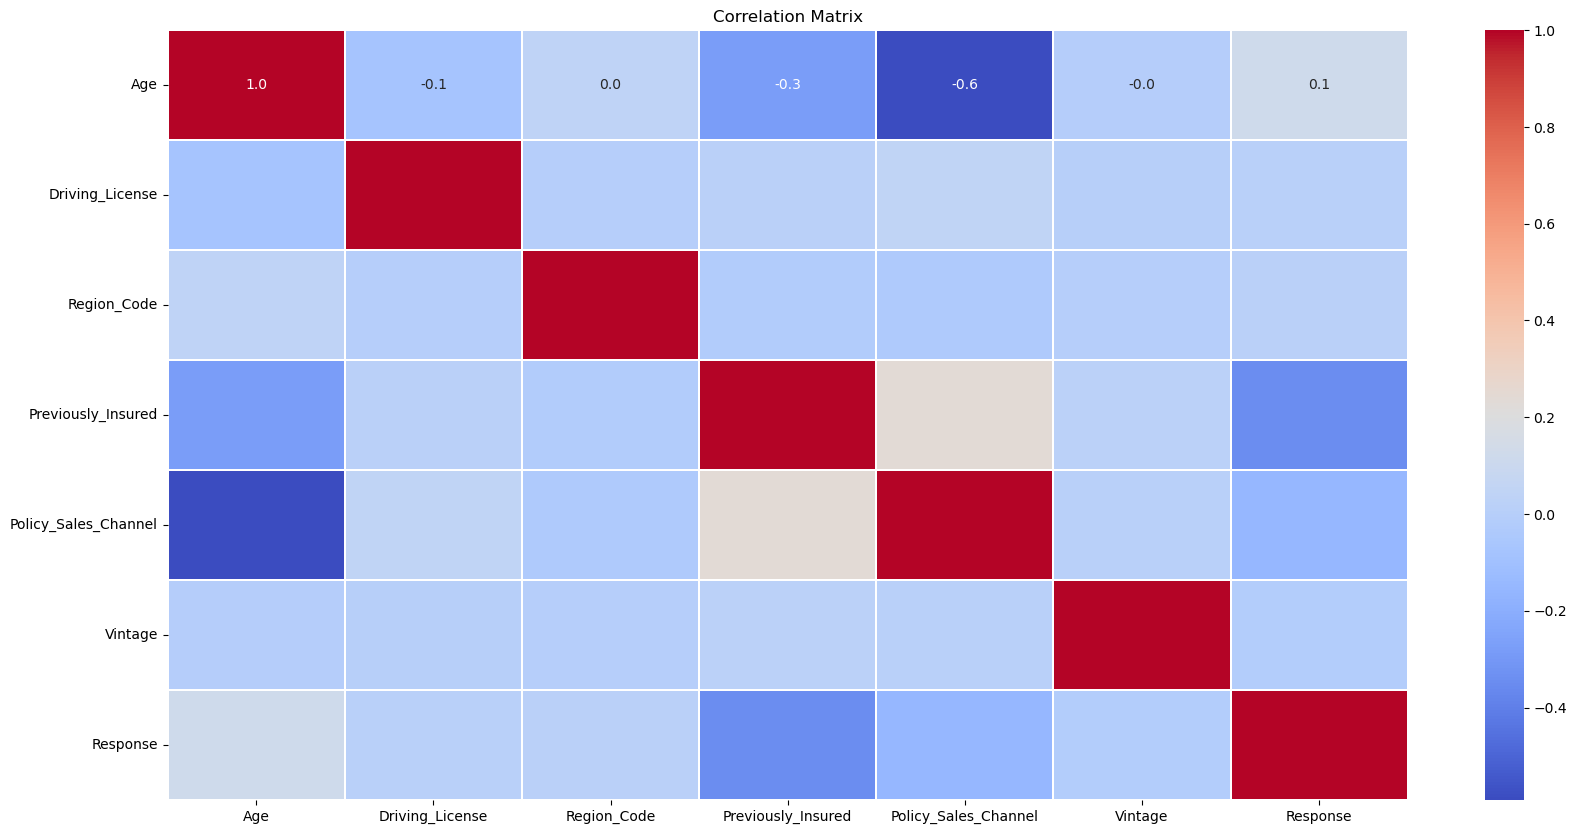

In [19]:
# Correlation matrix heatmap
correlation_matrix = data[numerical_cols].corr()
plt.figure(figsize=(20, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.1)
plt.title('Correlation Matrix')
plt.show()

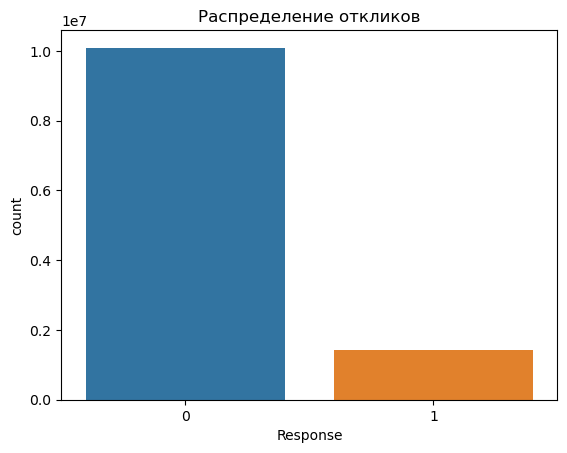

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


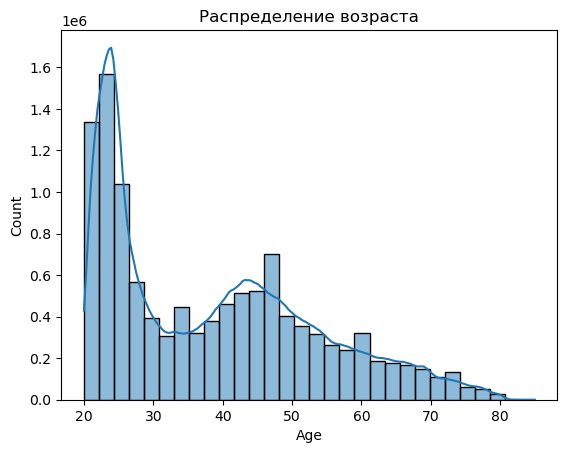

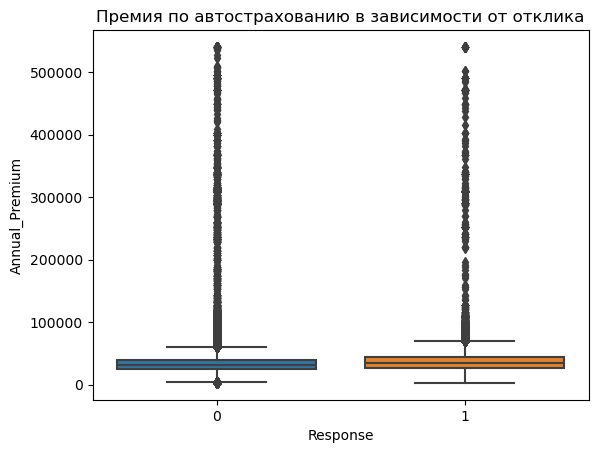

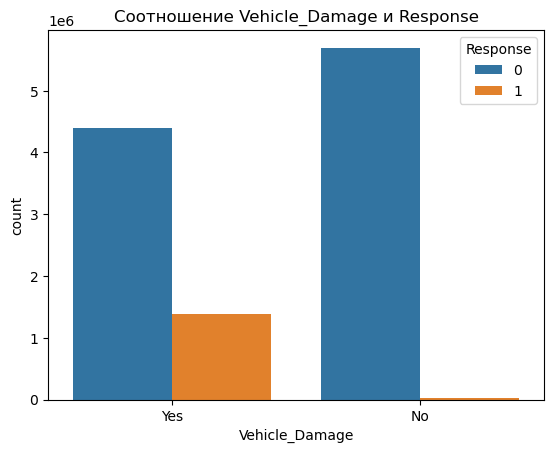

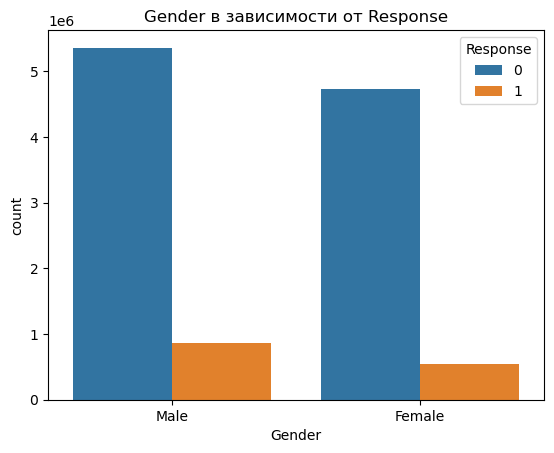

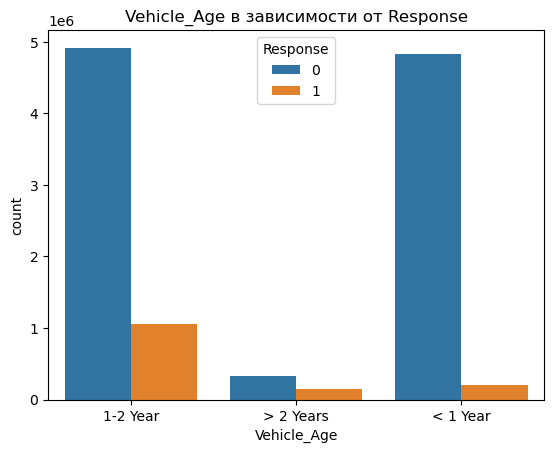

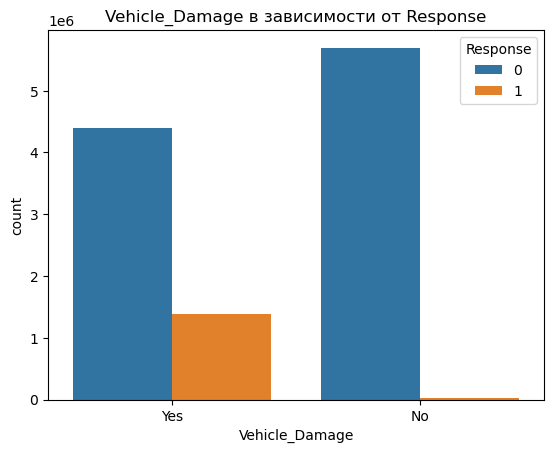

In [22]:
# Распределение целевой переменной
sns.countplot(x='Response', data=data)
plt.title('Распределение откликов')
plt.show()

# Распределение возрастов
sns.histplot(data['Age'], bins=30, kde=True)
plt.title('Распределение возраста')
plt.show()

# Взаимосвязь между откликом и другими признаками
sns.boxplot(x='Response', y='Annual_Premium', data=data)
plt.title('Премия по автострахованию в зависимости от отклика')
plt.show()

sns.countplot(x='Vehicle_Damage', hue='Response', data=data)
plt.title('Соотношение Vehicle_Damage и Response')
plt.show()


# Анализ категориальных признаков
categorical_cols = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']
for col in categorical_cols:
    sns.countplot(x=col, hue='Response', data=data)
    plt.title(f'{col} в зависимости от Response')
    plt.show()

# Построение и оценка модели

In [40]:
# Кодирование категориальных признаков
data['Gender'] = data['Gender'].map({'Male': 0, 'Female': 1})
data['Vehicle_Age'] = data['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2})
data['Vehicle_Damage'] = data['Vehicle_Damage'].map({'No': 0, 'Yes': 1})

# Разделение на признаки и целевую переменную
X = data.drop(['Response'], axis=1)
y = data['Response']

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

y_test = y_test.astype(int)

In [41]:
# Обучение модели Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10, class_weight='balanced')
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=10, random_state=42)

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.67      0.80   2017948
           1       0.28      0.94      0.43    283012

    accuracy                           0.70   2300960
   macro avg       0.64      0.80      0.62   2300960
weighted avg       0.90      0.70      0.75   2300960



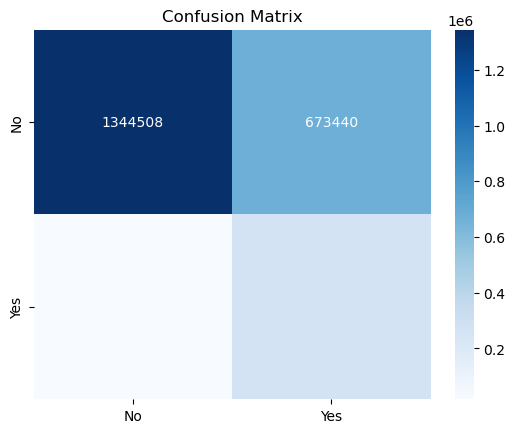

In [42]:
# Предсказания на тестовой выборке
y_pred = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

y_pred = y_pred.astype(int)
# Оценка модели
print("Classification Report:\n", classification_report(y_test, y_pred))

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
plt.title('Confusion Matrix')
plt.show()

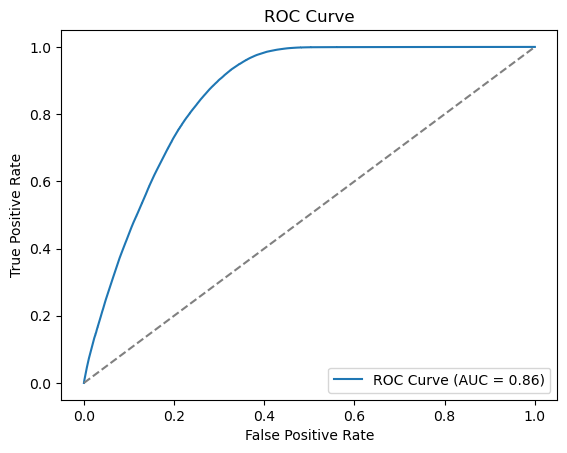

In [43]:
# ROC-AUC
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Результаы анализа
Класс 0 - негативная реакция на предложение по автострахованию

Класс 1 - положительная реакция на предложение по автострахованию

Из оценки модели:
1.	Дисбаланс классов: Класс 0 (2M) сильно преобладает над классом 1 (283K).
2.	Метрики для класса 1:

    • Recall: 0.94 (модель почти не упускает положительные объекты).

    • Precision: 0.28 (много ложных срабатываний).
3.	Accuracy: 70%, но из-за дисбаланса точность завышена.
4.	Вывод: Модель сильно смещена в сторону полноты для класса 1, но точность низкая. Требуется балансировка классов для улучшения качества.

Из матрицы ошибок видно, что большинство объектов принадлежат к классу “No” из-за этого возможна, проблема дисбаланса классов: модель обучилась предсказывать “No” чаще, чем “Yes”.

Из метрик оценки эффективности моделей ROC-AUC модель демонстрирует достаточно хорошее качество с AUC = 0.86